<a href="https://colab.research.google.com/github/Rafca15/FYP28-SymphonicAI/blob/main/MIDI_Transformerv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install miditok
!pip install miditoolkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
!unzip ./maestro-v3.0.0-midi

Archive:  ./maestro-v3.0.0-midi.zip
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1_2004_01_Track01_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_Track01_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_01_R1_2004_01-02_ORIG_MID--AUDIO_01_R1_2004_03_Track03_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_09_Track09_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_18_R1_2004_01-02_ORIG_MID--AUDIO_18_R1_2004_03_Track03_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_19_R1_2004_01-02_ORIG_MID--AUDIO_19_R1_2004_01_Track01_wav.midi  
  inflating: maestro-v3.0.0/2004/MIDI-Unprocessed_XP_04_R1_2004_06_ORIG_MID--AUDIO_04_R1_2004_08_Track08_wav.midi  
  inflating: maes

In [ ]:
!7z x Dataset.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1345976 bytes (1315 KiB)

Extracting archive: Dataset.7z
--
Path = Dataset.7z
Type = 7z
Physical Size = 1345976
Headers Size = 41547
Method = LZMA2:12m
Solid = +
Blocks = 1

  0%      0% 785 - Dataset/bassanog-fantasia20-a3_track_3.mid                                                       0% 1206 - Dataset/carwardenj-suite4-20-pavan_track_2.mid                                                            0% 1528 - Dataset/coprarioj-fantasia13-a5_track_3.mid

In [ ]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random
from miditok import REMI, TokenizerConfig
from miditok.pytorch_data import DatasetMIDI
from miditoolkit import MidiFile

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:

TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "use_time_signatures": True,
    "use_programs": True,
    "num_tempos": 32,
    "tempo_range": (40, 250),
}

config = TokenizerConfig(**TOKENIZER_PARAMS)
tokenizer = REMI(config)

midi_paths = list(Path("/content/Dataset").rglob("*.mid")) + list(Path("/content/maestro-v3.0.0").rglob("*.midi"))
print(f"Found {len(midi_paths)} MIDI files.")
tokenizer.train(vocab_size=50000, model="BPE", files_paths=midi_paths)



/usr/local/lib/python3.11/dist-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


Found 1276 MIDI files.


In [ ]:
print(tokenizer)

tokenizer.save("tokenizer-maestro-50k.json")

50000 tokens with ('T',) io format (one token stream), trained with BPE


In [ ]:

raw_dataset = DatasetMIDI(
    files_paths=midi_paths,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)

class Seq2SeqMIDIDataset(Dataset):
    def __init__(self, base_dataset, eos_token_id):
        self.base_dataset = base_dataset
        self.eos_token_id = eos_token_id

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        for attempt in range(10):
            sample = self.base_dataset[idx]
            if sample is None or sample.get("input_ids") is None:
                idx = (idx + 1) % len(self.base_dataset)
                continue

            input_ids = sample["input_ids"]
            input_ids = input_ids[input_ids != self.eos_token_id]

            if len(input_ids) < 2:
                idx = (idx + 1) % len(self.base_dataset)
                continue

            targets = torch.cat((input_ids[1:], torch.tensor([self.eos_token_id])))
            return {"input_ids": input_ids, "labels": targets}


        return {"input_ids": torch.tensor([self.eos_token_id]), "labels": torch.tensor([self.eos_token_id])}

def collate_batch(batch):
    pad_token_id = tokenizer["PAD_None"] if "PAD_None" in tokenizer.special_tokens else 0

    input_ids = [item["input_ids"] for item in batch]
    labels = [item["labels"] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=pad_token_id)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)
    return {"input_ids": input_ids_padded, "labels": labels_padded}

train_dataset = Seq2SeqMIDIDataset(raw_dataset, tokenizer["EOS_None"])
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)


In [ ]:

class Head(nn.Module):
    def __init__(self, head_size, n_embd, block_size, dropout=0.1):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2, -1) / (C ** 0.5)

        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        return self.dropout(wei @ v)

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, n_embd, block_size, dropout=0.1):
        super().__init__()
        head_size = n_embd // num_heads
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.proj(torch.cat([h(x) for h in self.heads], dim=-1)))

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout=0.1):
        super().__init__()
        self.sa = MultiHeadAttention(n_head, n_embd, block_size, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerMIDILanguageModel(nn.Module):
    def __init__(self, vocab_size, n_embd=128, n_head=4, n_layer=6, block_size=1024, dropout=0.1):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size
        self.vocab_size = vocab_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))

        x = self.blocks(tok_emb + pos_emb)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1), ignore_index=-100)
        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0, eos_token_id=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature


            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

            if eos_token_id is not None and idx_next.item() == eos_token_id:
                break

        return idx





In [ ]:

def train_model(model, dataloader, num_epochs=3, lr=3e-4, checkpoint_path="midi_model.pt"):
    model.train()
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    step_losses = []
    epoch_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for step, batch in enumerate(dataloader):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            logits, loss = model(input_ids, targets=labels)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            step_losses.append(loss.item())
            total_loss += loss.item()

            if step % 50 == 0:
                print(f"[Epoch {epoch+1}] Step {step}/{len(dataloader)} - Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        perplexity = torch.exp(torch.tensor(avg_loss))
        print(f"✅ Epoch {epoch+1} Avg Loss: {avg_loss:.4f} | Perplexity: {perplexity:.2f}")
        torch.save(model.state_dict(), checkpoint_path)

    return step_losses, epoch_losses


def plot_losses(step_losses, epoch_losses):
    plt.figure(figsize=(10, 4))
    plt.plot(step_losses, label="Batch Loss", alpha=0.7)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss (Per Batch)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epoch_losses, marker='o', label="Epoch Avg Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training Loss (Per Epoch)")
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_midi(model, tokenizer, start_tokens, max_new_tokens=100, temperature=1.0, top_k=None, top_p=None, output_path="generated.mid", save_midi = False, eos_token_id = tokenizer["EOS_None"]):
    model.eval()
    idx = torch.tensor(start_tokens, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        generated = model.generate(idx, max_new_tokens=max_new_tokens, temperature=temperature, eos_token_id=eos_token_id)
    tokens = generated[0].tolist()
    midi = tokenizer.decode(tokens)

    if save_midi:
      midi.dump_midi(output_path)
      print(f"🎵 MIDI saved to {output_path}")

    return midi


In [ ]:

vocab_size = len(tokenizer)
model = TransformerMIDILanguageModel(vocab_size=vocab_size)



In [ ]:
print(model)

TransformerMIDILanguageModel(
  (token_embedding_table): Embedding(50000, 128)
  (position_embedding_table): Embedding(1024, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (ln1): LayerNorm((128,

In [ ]:
step_losses, epoch_losses = train_model(model, dataloader, num_epochs=30)


[Epoch 1] Step 0/1018 - Loss: 10.9917
[Epoch 1] Step 10/1018 - Loss: 10.9683
[Epoch 1] Step 20/1018 - Loss: 10.5394
[Epoch 1] Step 30/1018 - Loss: 10.6625
[Epoch 1] Step 40/1018 - Loss: 10.3707
[Epoch 1] Step 50/1018 - Loss: 10.2464
[Epoch 1] Step 60/1018 - Loss: 10.5559
[Epoch 1] Step 70/1018 - Loss: 10.2334
[Epoch 1] Step 80/1018 - Loss: 10.2175
[Epoch 1] Step 90/1018 - Loss: 9.9742
[Epoch 1] Step 100/1018 - Loss: 9.7498
[Epoch 1] Step 110/1018 - Loss: 9.7799
[Epoch 1] Step 120/1018 - Loss: 9.9573
[Epoch 1] Step 130/1018 - Loss: 9.9998
[Epoch 1] Step 140/1018 - Loss: 9.8170
[Epoch 1] Step 150/1018 - Loss: 10.0951
[Epoch 1] Step 160/1018 - Loss: 10.1199
[Epoch 1] Step 170/1018 - Loss: 9.8632
[Epoch 1] Step 180/1018 - Loss: 9.6914
[Epoch 1] Step 190/1018 - Loss: 9.9151
[Epoch 1] Step 200/1018 - Loss: 9.3144
[Epoch 1] Step 210/1018 - Loss: 9.9457
[Epoch 1] Step 220/1018 - Loss: 9.8744
[Epoch 1] Step 230/1018 - Loss: 9.8018
[Epoch 1] Step 240/1018 - Loss: 9.4253
[Epoch 1] Step 250/1018 -

In [ ]:
torch.save(model , "iteration2.pth")

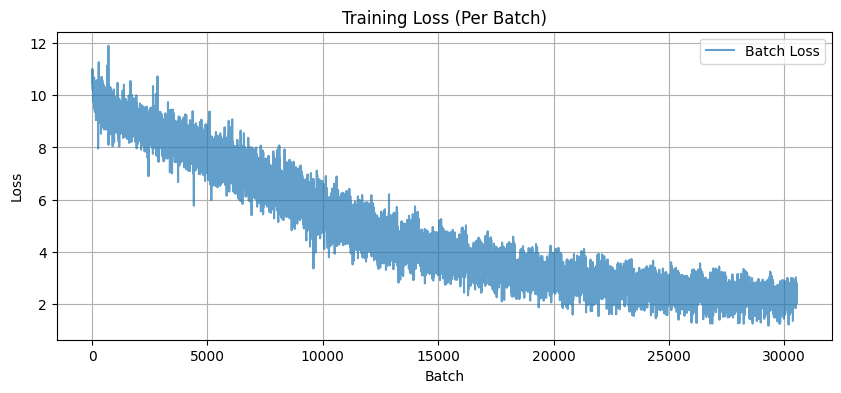

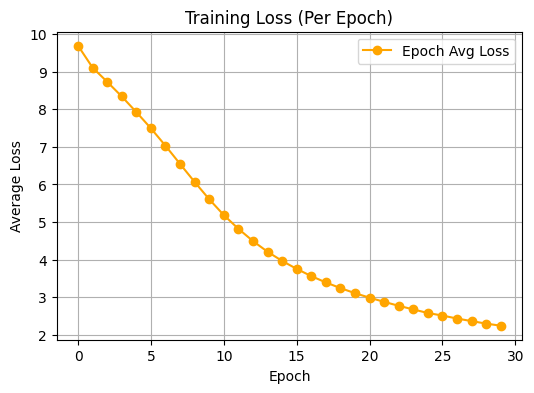

In [ ]:
plot_losses(step_losses, epoch_losses)

In [ ]:
context = midi_paths[1]
start = [list(tokenizer(midi_paths[0]))][0]

print(start[:100])

startcontext = [tokenizer["BOS_None"], tokenizer["Program_0"]]

#def generate_midi(model, tokenizer, start_tokens, max_new_tokens=100, temperature=1.0, top_k=None, top_p=None, output_path="generated.mid", save_midi = False, eos_token_id = tokenizer["EOS_None"]):

generatedmidi = generate_midi(model, tokenizer, start_tokens=start, max_new_tokens=100, output_path="23mars_6.mid", save_midi= True , eos_token_id=tokenizer["Bar_None"])

tokens = [list(tokenizer.encode(generatedmidi))][0]

print(tokens)

[1213, 6536, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 48732, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 1015, 27386, 575, 575, 575, 575, 575, 575, 575, 833, 2854, 400, 11234, 22319, 1360, 30894, 16731, 7428, 5611, 209, 5809, 4915, 32139, 25343, 8872, 5809, 1173, 1129, 22319, 8623, 6964, 14899, 29020, 2296, 5809, 1173, 30894, 1360, 30894, 7652, 11499, 2295, 18743, 5170, 10327, 27433, 1870, 17697, 363, 1360, 1057, 995, 35881, 363, 1360, 1651]
🎵 MIDI saved to 23mars_6.mid
[1213, 6536, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 48732, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 1015, 27386, 575, 575, 575, 575, 575, 575, 575, 833, 2854, 400, 11234, 22319, 1360, 30894, 16731, 7428, 5611, 209, 5809, 4915, 32139, 25343, 8872, 5809, 1173, 1129, 22319, 8623, 69

In [ ]:
import matplotlib.pyplot as plt

def plotmidi(list1, list2):

  plt.figure(figsize=(10, 6))

  x_values1 = list(range(len(list1)))
  plt.scatter(x_values1, list1, color='blue', label='List 1', marker='.')

  x_values2 = list(range(len(list2)))
  plt.scatter(x_values2, list2, color='red', label='List 2', marker='.')


  for i in range(min(len(list1), len(list2))):
    if list1[i] == list2[i]:
      plt.scatter(i, list1[i], color='purple', alpha=0.5, marker='.')

  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('MIDI Plot')
  plt.legend()
  plt.grid(True)
  plt.show()


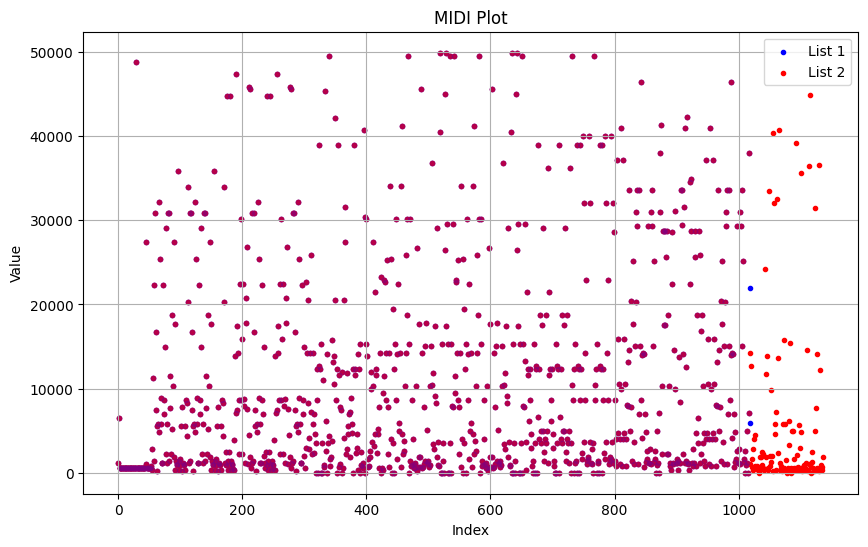

In [ ]:
plotmidi(start, tokens)

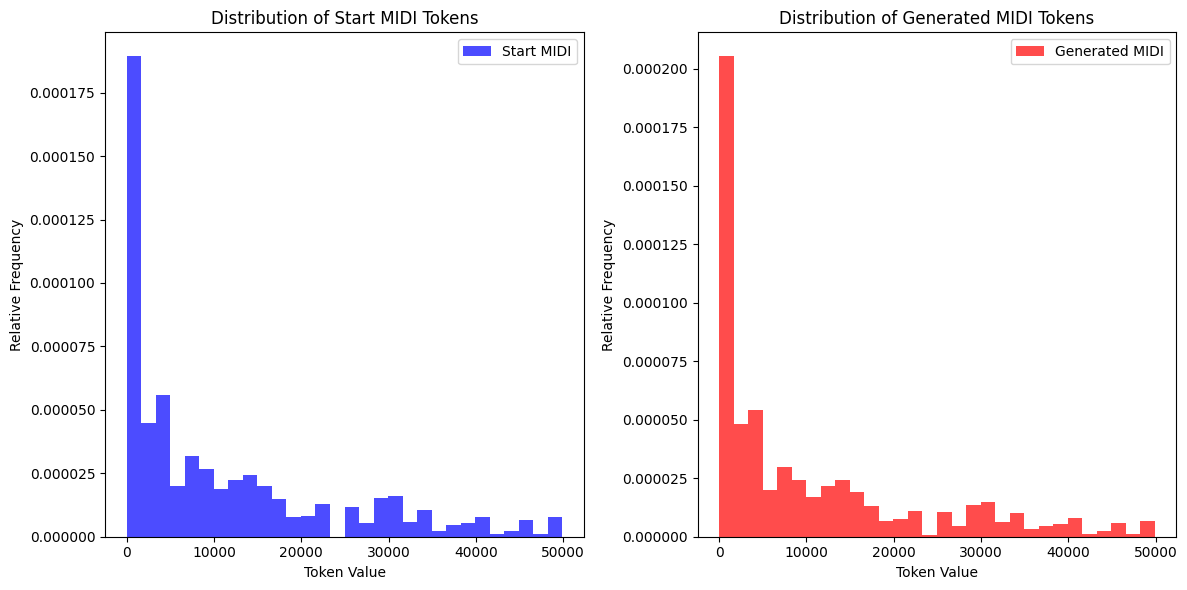

In [ ]:

def plot_midi_distributions(start, tokens):


  purple_values = []
  for i in range(min(len(start), len(tokens))):
      if start[i] == tokens[i]:
          purple_values.append(start[i])

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.hist(start, bins=30, color='blue', alpha=0.7, label='Start MIDI', density=True)
  plt.xlabel('Token Value')
  plt.ylabel('Relative Frequency')
  plt.title('Distribution of Start MIDI Tokens')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.hist(tokens, bins=30, color='red', alpha=0.7, label='Generated MIDI', density=True)
  plt.xlabel('Token Value')
  plt.ylabel('Relative Frequency')
  plt.title('Distribution of Generated MIDI Tokens')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_midi_distributions(start, tokens)


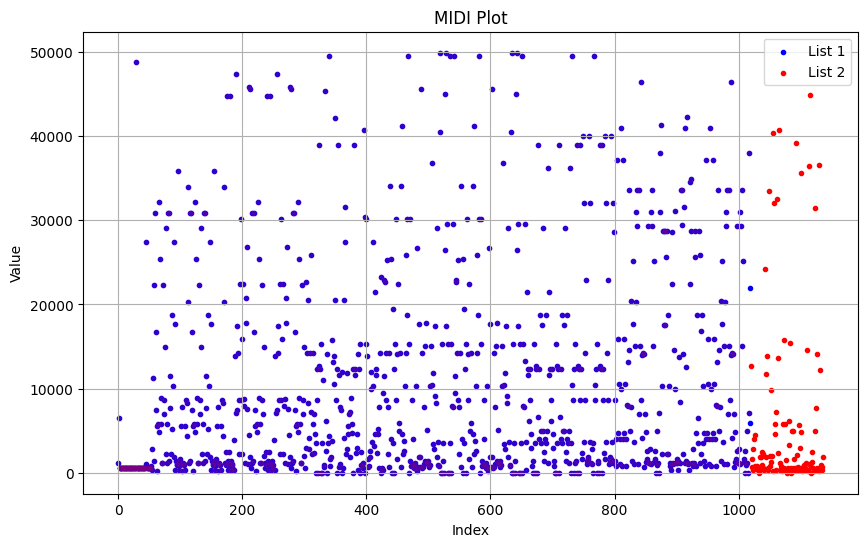

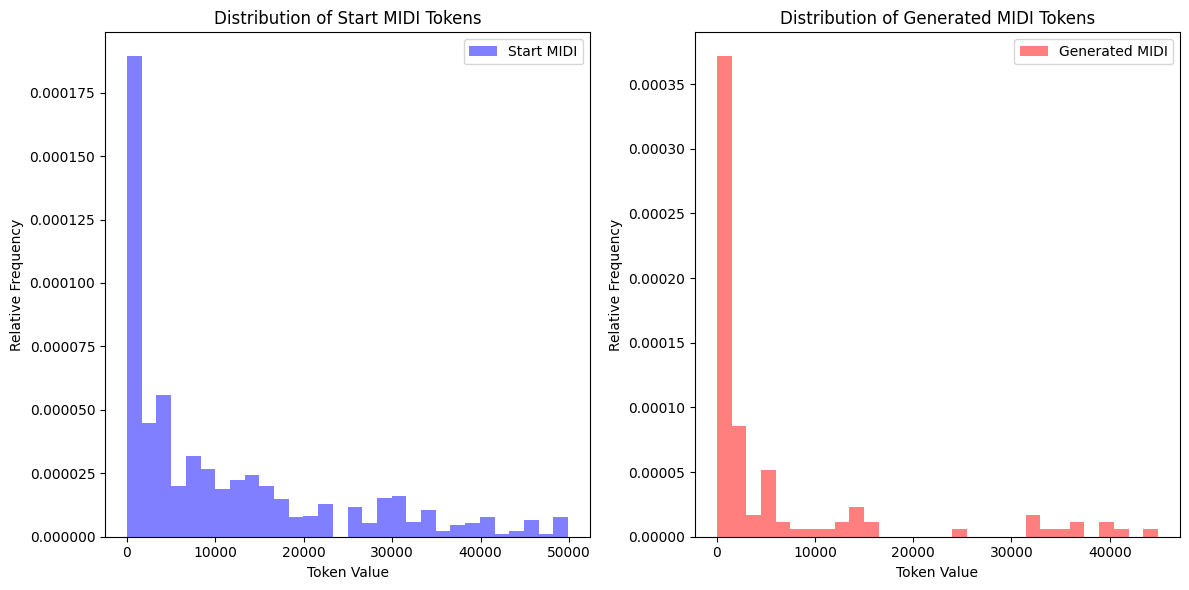

Kolmogorov-Smirnov test statistic: 0.3251
P-value: 0.0000
The distributions are significantly different.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

def plotmidi(list1, list2):

  plt.figure(figsize=(10, 6))

  x_values1 = list(range(len(list1)))
  plt.scatter(x_values1, list1, color='blue', label='List 1', marker='.')

  last_blue_index = len(list1) - 1
  red_after_blue = []
  for i in range(len(list2)):
    if i > last_blue_index:
      red_after_blue.append(list2[i])


  x_values2 = list(range(last_blue_index + 1, last_blue_index + 1 + len(red_after_blue)))
  plt.scatter(x_values2, red_after_blue, color='red', label='List 2', marker='.')


  for i in range(min(len(list1), len(list2))):
    if list1[i] == list2[i]:
      plt.scatter(i, list1[i], color='purple', alpha=0.3, marker='.')


  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('MIDI Plot')
  plt.legend()
  plt.grid(True)
  plt.show()

plotmidi(start, tokens)

def plot_midi_distributions(start, tokens):
  last_blue_index = len(start) - 1
  red_after_blue = []
  for i in range(len(tokens)):
    if i > last_blue_index:
      red_after_blue.append(tokens[i])

  purple_values = []
  for i in range(min(len(start), len(tokens))):
      if start[i] == tokens[i]:
          purple_values.append(start[i])

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.hist(start, bins=30, color='blue', alpha=0.5, label='Start MIDI', density=True)
  plt.xlabel('Token Value')
  plt.ylabel('Relative Frequency')
  plt.title('Distribution of Start MIDI Tokens')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.hist(red_after_blue, bins=30, color='red', alpha=0.5, label='Generated MIDI', density=True)
  plt.xlabel('Token Value')
  plt.ylabel('Relative Frequency')
  plt.title('Distribution of Generated MIDI Tokens')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_midi_distributions(start, tokens)



def compare_distributions(start, tokens):
  last_blue_index = len(start) - 1
  red_after_blue = []
  for i in range(len(tokens)):
    if i > last_blue_index:
      red_after_blue.append(tokens[i])

  statistic, p_value = ks_2samp(start, red_after_blue)

  print(f"Kolmogorov-Smirnov test statistic: {statistic:.7f}")
  print(f"P-value: {p_value:.7f}")

  if p_value < 0.05:
      print("The distributions are significantly different.")
  else:
      print("There is no significant difference between the distributions.")


compare_distributions(start, tokens)
